In [4]:
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import ast
import time
#import lpips
#import torch

import random

In [5]:
def normalize_list_sklearn(lst):
    scaler = MinMaxScaler()
    return scaler.fit_transform([[x] for x in lst]).flatten()

In [6]:
def extract_frames(video_path, output_folder):
    """
    Extracts frames from a video file and saves them as images in a folder.
    
    Args:
        video_path (str): Path to the video file.
        output_folder (str): Path to the folder where frames will be saved.
    
    Returns:
        int: The number of frames extracted.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")
    
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        
        # Save the frame as an image file
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_count += 1
    
    # Release the video capture object
    video.release()
    
    print(f"Extracted {frame_count} frames to '{output_folder}'")
    return frame_count

In [193]:
def time_analysis(image_path1, image_path2):

    execution_times = []
    
    # Read the images
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    # Check if images were loaded correctly
    if image1 is None or image2 is None:
        raise ValueError("One or both image paths are invalid or the images cannot be read.")
    
    # Resize images to the same dimensions, if necessary
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    
    
    # SSIM
    start_time = time.perf_counter()
    
    ssim(image1, image2, full=True)
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("ssim", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")
  

    # MSE
    start_time = time.perf_counter()
    
    np.mean((image1 - image2) ** 2)
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("mse", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    # PSNR
    mse_value = np.mean((image1 - image2) ** 2)
    if mse_value == 0:  # Images are identical
        float('inf')
    max_pixel = 255.0
    start_time = time.perf_counter()
    
    20 * np.log10(max_pixel / np.sqrt(mse_value))/30
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("pnsr", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    # ORB
    start_time = time.perf_counter()
    
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    len(matches)
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("orb", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    # HISTOGRAM
    start_time = time.perf_counter()
    
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
    cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("histogram", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    # Pearson's Correlation 2
    start_time = time.perf_counter()
    
    image111 = image1.flatten()
    image222 = image2.flatten()
    pearsonr(image111, image222)[0]
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("cor1", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    # Pearson's Correlation 3
    start_time = time.perf_counter()
    
    image1111 = image1.flatten()
    image2222 = image2.flatten()
    
    np.corrcoef(image1111, image2222)[0,1]
    
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times.append( ("cor2", execution_time) )
    print(f"Execution time: {execution_time:.4f} seconds")

    
    return execution_times

In [8]:
def compare_images(func, image_path1, image_path2):
    # Read the images
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    # Check if images were loaded correctly
    if image1 is None or image2 is None:
        raise ValueError("One or both image paths are invalid or the images cannot be read.")
    
    # Resize images to the same dimensions, if necessary
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    # Compute SSIM between the images
    if func == 'ssim':
        similarity, _ = ssim(image1, image2, full=True)

    #very inefficient
    elif func == 'ncc':
        image1 = np.array(image1)
        image2 = np.array(image2)
        similarity = correlate2d(image1, image2, boundary='symm', mode='same').max()
        
    elif func == 'mse':
        similarity = np.mean((image1 - image2) ** 2)
        
    elif func == 'psnr':
        mse_value = np.mean((image1 - image2) ** 2)
        if mse_value == 0:  # Images are identical
            return float('inf')
        max_pixel = 255.0
        similarity = 20 * np.log10(max_pixel / np.sqrt(mse_value))/30
        
    elif func == 'orb':
        orb = cv2.ORB_create()
        keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(image2, None)
        
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1, descriptors2)
        similarity = len(matches)

    elif func == 'histogram':
        hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
        hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
        similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    elif func == 'lpips':
        loss_fn = lpips.LPIPS(net='alex')  # Pretrained on AlexNet
        image1_tensor = image1
        image2_tensor = image2
        similarity = loss_fn(image1_tensor, image2_tensor)

  
    elif func == 'cor2':
        # Calculate correlation
        image1 = image1.flatten()
        image2 = image2.flatten()
        similarity = pearsonr(image1, image2)[0]
    
    elif func == 'cor3':
        # Calculate correlation
        image1 = image1.flatten()
        image2 = image2.flatten()
        similarity = np.corrcoef(image1, image2)[0,1]

    elif func == 'diff':
        # Calculate correlation
        image1 = image1.flatten()
        image2 = image2.flatten()
        diff = np.subtract(image1, image2)
        similarity = diff
    
    return similarity

In [9]:
import pandas as pd

In [10]:
image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
if image1 is None or image2 is None:
    raise ValueError("One or both image paths are invalid or the images cannot be read.")

# Resize images to the same dimensions, if necessary
if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
image1 = image1.flatten()
image2 = image2.flatten()


img1 = pd.Series(image1)
img2 = pd.Series(image2)

print(img1.corr(img2))

start_time = time.perf_counter()

img1.corr(img2)

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")


<class 'NameError'>: name 'image_path1' is not defined

In [11]:
def similarity_Signal(func):
    simSig = []

    image_path1 = "output_frames/frame_0001.jpg"
    for i in range(305):
        image_path2 = "output_frames/frame_" + f"{i:04}" +".jpg"
        
        simSig.append(compare_images(func,image_path1, image_path2))
    
    return simSig

In [12]:
def plot_similarity(sim_metric, y_values, y_range):
    # Generate x values in the range from -1 to 1
    x = np.linspace(0, 305, 305)  # 100 points between -1 and 1
    
    # Define a function to plot, e.g., y = x^2
    y = y_values
    
    # Create the plot
    plt.plot(x, y, label=sim_metric)
    plt.ylim(y_range[0], y_range[1])
    
    # Add labels and title
    plt.xlabel("frame")
    plt.ylabel("similarity")
    plt.title("Frames Similarities to frame 0001")
    
    # Add a legend
    plt.legend()
    
    # Show the grid
    plt.grid()
    
    # Display the plot
    plt.show()

In [185]:
def subplot_similarity(subpl, sim_metric, y_values, y_range):
    # Generate x values in the range from -1 to 1
    x = np.linspace(0, 305, 305)  # 100 points between -1 and 1
    
    # Define a function to plot, e.g., y = x^2
    y = y_values
    
    # Create the plot
    plt.subplot(2, 1, subpl)
    plt.plot(x, y, label=sim_metric)
    plt.ylim(y_range[0], y_range[1])
    
    # Add labels and title
    plt.xlabel("frame")
    plt.ylabel("similarity")
    plt.title("Frames Similarities to frame 0001")
    
    # Add a legend
    plt.legend()
    
    # Show the grid
    plt.grid()
    
    # Display the plot
    plt.show()

In [15]:
extract_frames('pizza.mp4', 'output_frames')

Extracted 305 frames to 'output_frames'


305

In [5]:
with open('signals.txt', 'a') as output:
    signal = similarity_Signal('ssim')
    output.write(str(signal))
    
    signal = similarity_Signal('mse')
    output.write(str(signal))
    
    signal = similarity_Signal('psnr')
    output.write(str(signal))
    
    signal = similarity_Signal('orb')
    output.write(str(signal))
    
    signal = similarity_Signal('histogram')
    output.write(str(signal))
    
    signal = similarity_Signal('cor2')
    output.write(str(signal))
    
    signal = similarity_Signal('cor3')
    output.write(str(signal))
    


In [14]:
# opening the file in read mode 
my_file = open("signals.txt", "r") 
  
# reading the file 
data = my_file.read() 
  
# replacing end of line('/n') with ' ' and 
# splitting the text it further when '.' is seen. 
data_into_list = data.replace(']', ']\n').split('\n')

my_file.close()


In [15]:
mse_list = ast.literal_eval(data_into_list[1])
MAX = max(mse_list)
mse_list = [MAX - x for x in mse_list]

In [ ]:
plot_similarity('SSIM', ast.literal_eval(data_into_list[0]), (0,1))
plot_similarity('MSE', mse_list, (0,100))
plot_similarity('PNSR', ast.literal_eval(data_into_list[2].replace('inf', '1.25')), (0,2))
plot_similarity('ORB', ast.literal_eval(data_into_list[3]), (0,500))
plot_similarity('Histogram', ast.literal_eval(data_into_list[4]), (0,1))
plot_similarity('Pearson Cor. 1', ast.literal_eval(data_into_list[5]), (0,1))
plot_similarity('Pearson Cor. 2', ast.literal_eval(data_into_list[6]), (0,1))

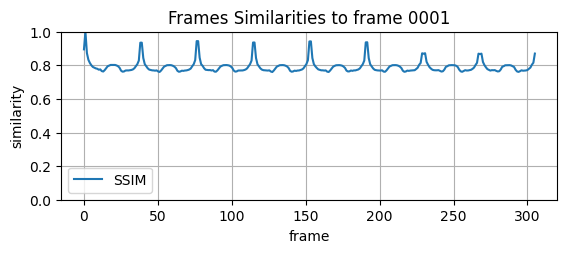

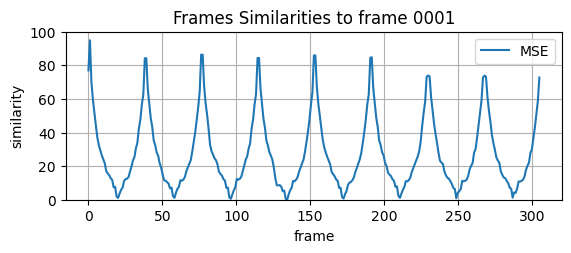

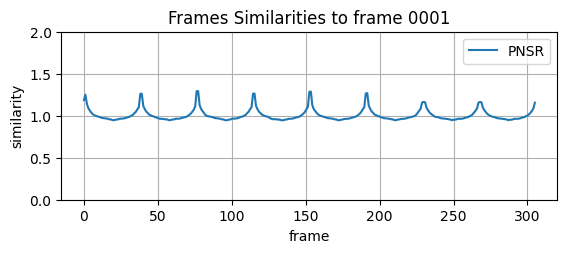

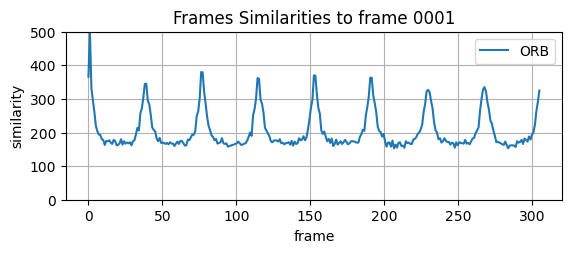

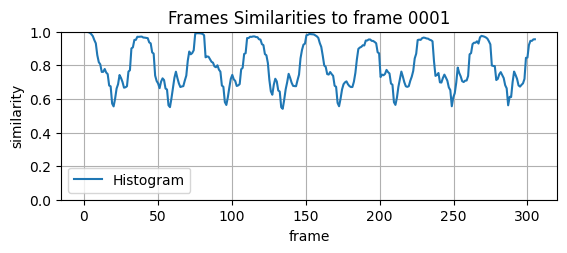

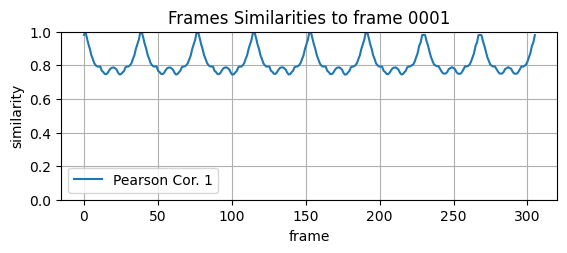

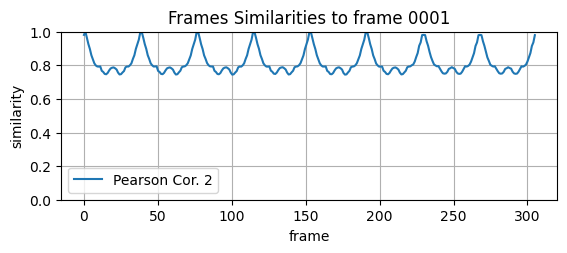

In [190]:
subplot_similarity(1,'SSIM', ast.literal_eval(data_into_list[0]), (0,1))
subplot_similarity(1,'MSE', mse_list, (0,100))
subplot_similarity(1,'PNSR', ast.literal_eval(data_into_list[2].replace('inf', '1.25')), (0,2))
subplot_similarity(1,'ORB', ast.literal_eval(data_into_list[3]), (0,500))
subplot_similarity(1,'Histogram', ast.literal_eval(data_into_list[4]), (0,1))
subplot_similarity(1,'Pearson Cor. 1', ast.literal_eval(data_into_list[5]), (0,1))
subplot_similarity(1,'Pearson Cor. 2', ast.literal_eval(data_into_list[6]), (0,1))

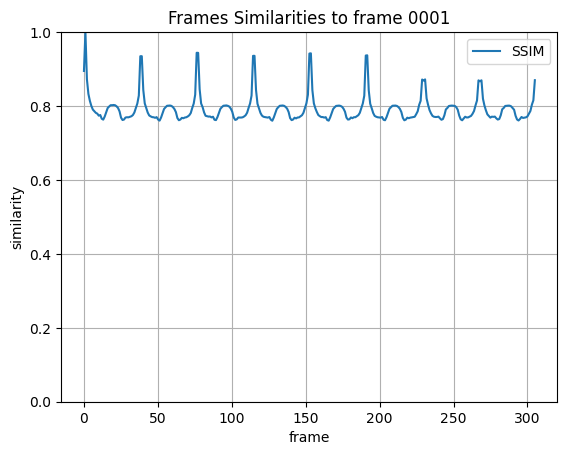

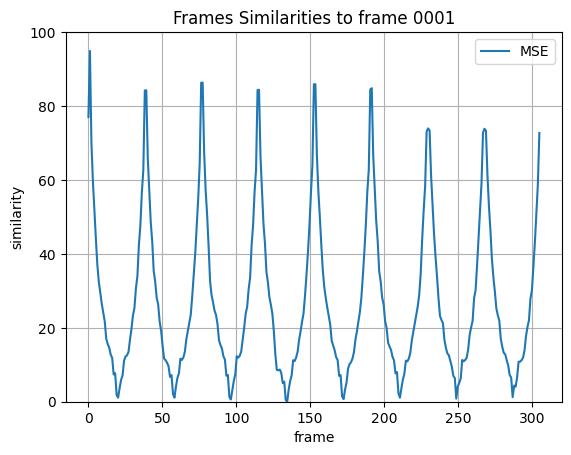

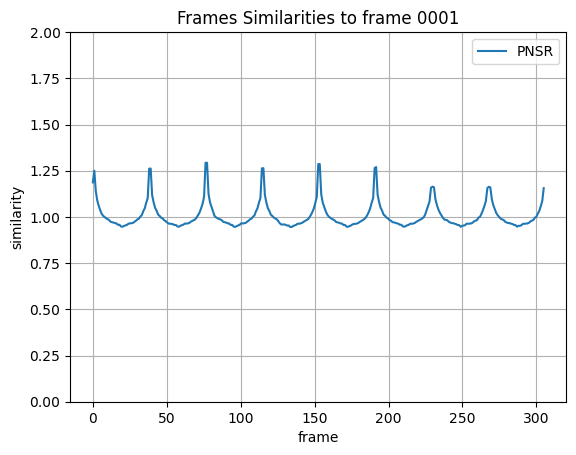

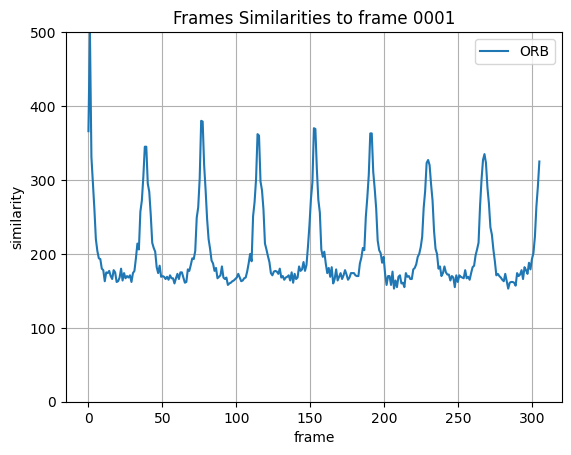

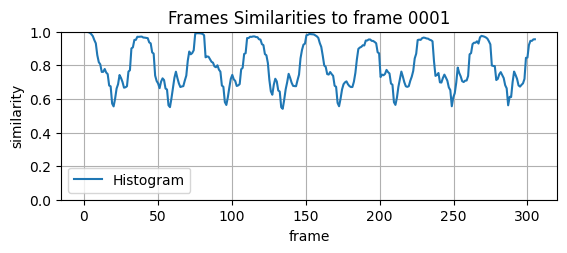

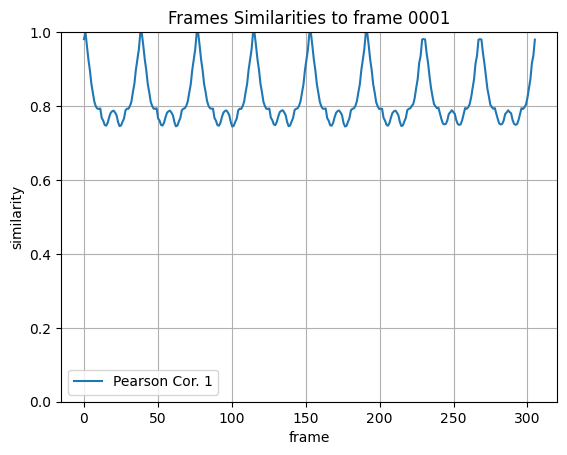

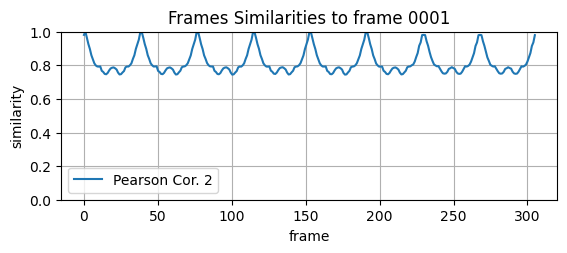

In [189]:
plot_similarity('SSIM', ast.literal_eval(data_into_list[0]), (0,1))
plot_similarity('MSE', mse_list, (0,100))
plot_similarity('PNSR', ast.literal_eval(data_into_list[2].replace('inf', '1.25')), (0,2))
plot_similarity('ORB', ast.literal_eval(data_into_list[3]), (0,500))
plot_similarity('Histogram', ast.literal_eval(data_into_list[4]), (0,1))
plot_similarity('Pearson Cor. 1', ast.literal_eval(data_into_list[5]), (0,1))
plot_similarity('Pearson Cor. 2', ast.literal_eval(data_into_list[6]), (0,1))

In [179]:
ls_SSIM = ast.literal_eval(data_into_list[0])
ls_MSE = mse_list
ls_PNSR = ast.literal_eval(data_into_list[2].replace('inf', '1.25'))
ls_ORB = ast.literal_eval(data_into_list[3])
ls_Histogram = ast.literal_eval(data_into_list[4])
ls_PearsonCor1 = normalize_list_sklearn(ast.literal_eval(data_into_list[5]))
ls_PearsonCor2 = ast.literal_eval(data_into_list[6])

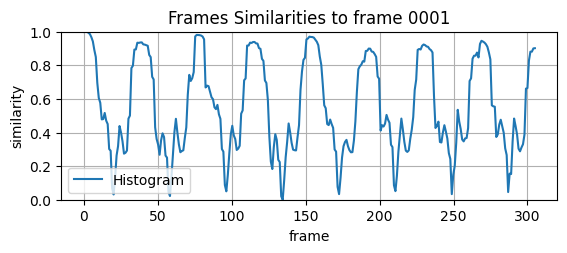

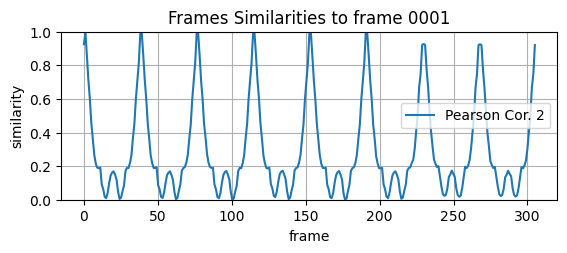

In [192]:
subplot_similarity(1,'Histogram', normalize_list_sklearn(ast.literal_eval(data_into_list[4])), (0,1))
subplot_similarity(1,'Pearson Cor. 2', normalize_list_sklearn(ast.literal_eval(data_into_list[6])), (0,1))

In [20]:
def second_max_index(arr):
    # Find the index of the maximum value
    max_index = np.argmax(arr)

    # Create a copy of the array and set the maximum value to negative infinity
    arr_copy = np.copy(arr)
    arr_copy[max_index] = -np.inf

    # Find the index of the second maximum value
    second_max_index = np.argmax(arr_copy)

    return second_max_index

In [194]:

trials = []
for i in range (10):
    fr1 = random.randint(1, 304)
    fr2 = random.randint(1, 304)
    image_path1 = "output_frames/frame_" + f"{fr1:04}" +".jpg"
    image_path2 = "output_frames/frame_" + f"{fr2:04}" +".jpg"
    
    trials.append(time_analysis(image_path1, image_path2))
    print()


Execution time: 1.2312 seconds
Execution time: 0.0448 seconds
Execution time: 0.0008 seconds
Execution time: 0.6950 seconds
Execution time: 0.0086 seconds
Execution time: 0.1310 seconds
Execution time: 0.0563 seconds

Execution time: 0.7122 seconds
Execution time: 0.0113 seconds
Execution time: 0.0000 seconds
Execution time: 0.7728 seconds
Execution time: 0.0106 seconds
Execution time: 0.1360 seconds
Execution time: 0.0546 seconds

Execution time: 0.6962 seconds
Execution time: 0.0068 seconds
Execution time: 0.0000 seconds
Execution time: 0.6574 seconds
Execution time: 0.0156 seconds
Execution time: 0.1229 seconds
Execution time: 0.0735 seconds

Execution time: 0.7681 seconds
Execution time: 0.0080 seconds
Execution time: 0.0001 seconds
Execution time: 0.6481 seconds
Execution time: 0.0179 seconds
Execution time: 0.1417 seconds
Execution time: 0.0512 seconds

Execution time: 0.7534 seconds
Execution time: 0.0190 seconds
Execution time: 0.0000 seconds
Execution time: 0.7333 seconds
Exec

In [245]:
def time_plot(time_result):
    ys = [pair[1] for pair in time_result]
    xs = [pair[0] for pair in time_result]

    plt.subplot(2,1,1)
    plt.ylabel("Time complexity (s)")
    plt.xlabel("Similarity function")
    plt.plot(xs, ys, marker='.')

    # Add labels to each point
    for i, j in zip(xs, ys):
        plt.text(i, j, f"{j:.2}")
        
    plt.show()
    # Make sure to close the plt object once done
    plt.close()

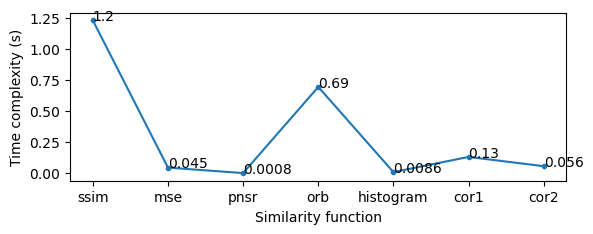

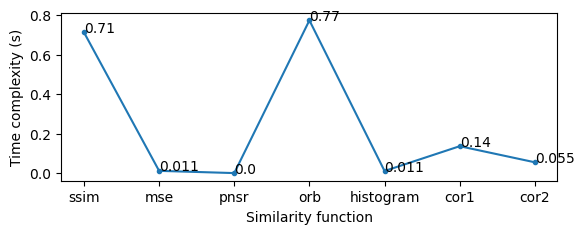

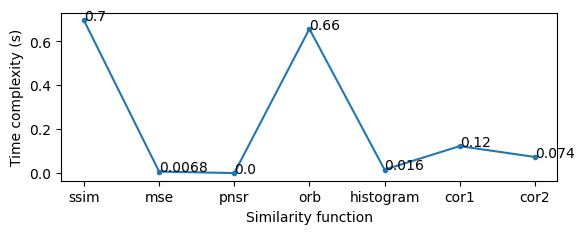

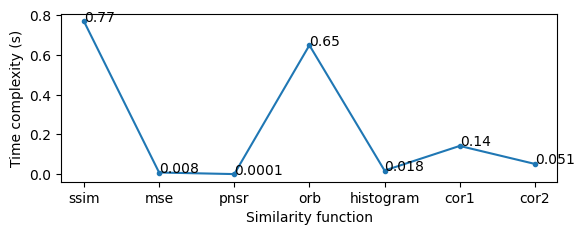

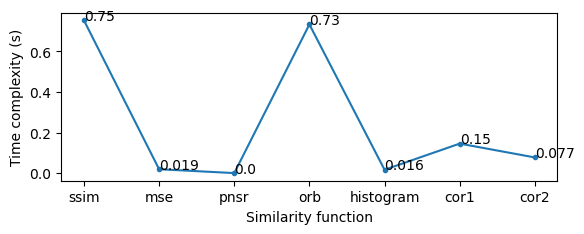

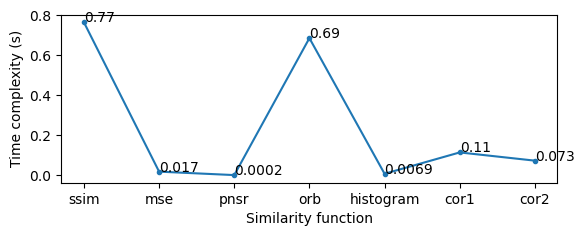

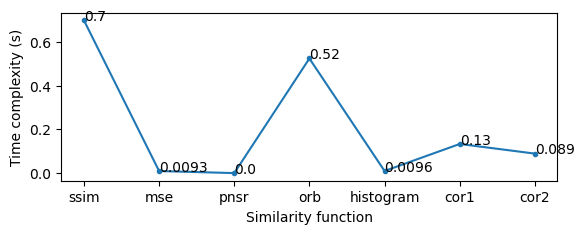

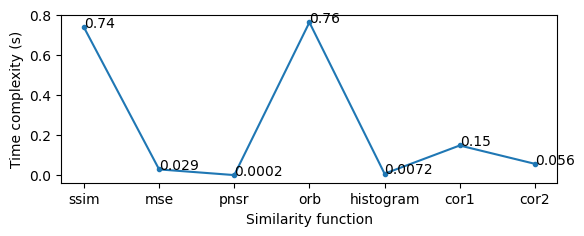

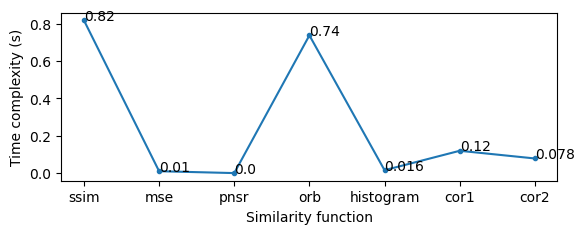

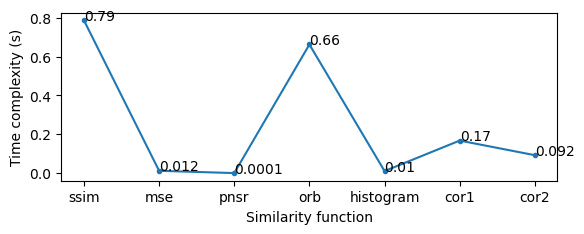

In [246]:
for tr in trials:
    time_plot(tr)


In [26]:
def find_period(signal):
    # Sample data
    x = np.linspace(0, 305, 305)
    y = signal
    
    # Calculate FFT
    yf = fft(y)
    xf = fftfreq(len(y), x[1] - x[0])
  
    # Find the dominant frequency
    dominant_frequency = xf[second_max_index(np.abs(yf))]
    
    # Calculate the period
    period = 1 / dominant_frequency
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 2)
    plt.plot(x, y)
    plt.title('Original Signal')

    #xf = np.where(xf >= 0)
    
    plt.subplot(2, 2, 1)
    plt.plot(xf, np.abs(yf))
    plt.title('FFT')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    print("\t\t\tDominant Frequency: %.3f , Period: %.3f" %(dominant_frequency, period))

In [27]:
def autoCorrelation(signal):

    fs = 305  # Sampling rate
    #f = 10    # Frequency of the sine wave
    t = np.arange(0, 1, 1/fs) # Time vector
    #signal = np.sin(2 * np.pi * f * t)

    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal)-1:] # Only take positive lags

    peaks = np.diff(np.sign(np.diff(autocorr))) < 0 # Find local maxima
    peak_indexes = np.where(peaks)[0] + 1
    
    if len(peak_indexes) <= 0:
        print("\t\t\tNo clear period found.")
        period = 0
    else:
      
        period = peak_indexes[0] / fs # Period in seconds
        print(f"\t\tPeriod: {(305/25)*period:.3f} seconds" ,end = "")
        print(f"\tPeriod: {305*period:.3f} frames") # 25 frames / second
        
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 2)
    plt.plot(t*(305/25), signal)
    plt.title("Signal")

    plt.subplot(2, 2, 1)
    plt.plot((305/25)*np.arange(len(autocorr))/fs, autocorr)
    plt.title("Autocorrelation")
    plt.xlabel("Lag (seconds)")
    plt.scatter((305/25)*period, autocorr[int(period*fs)], color='red', marker='o', label=f'Period: {(305/25)*period:.3f} s')
    plt.legend()
    plt.tight_layout()
    plt.show()

		Period: 1.200 seconds	Period: 30.000 frames


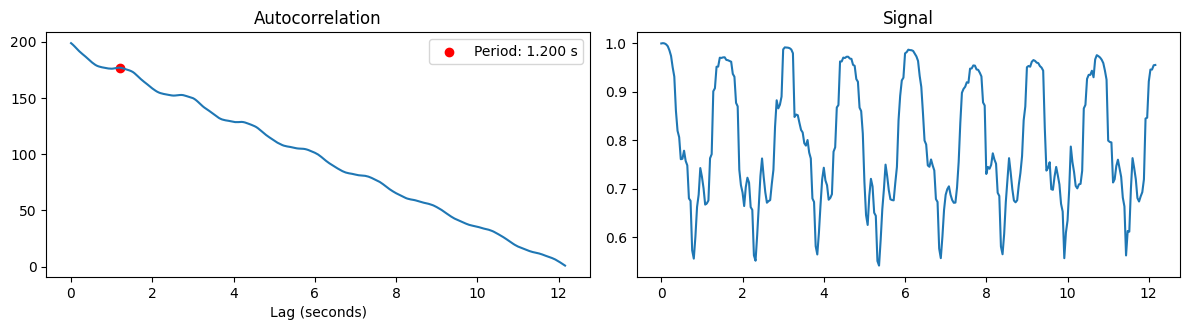

In [194]:
autoCorrelation(ls_Histogram)

			No clear period found.


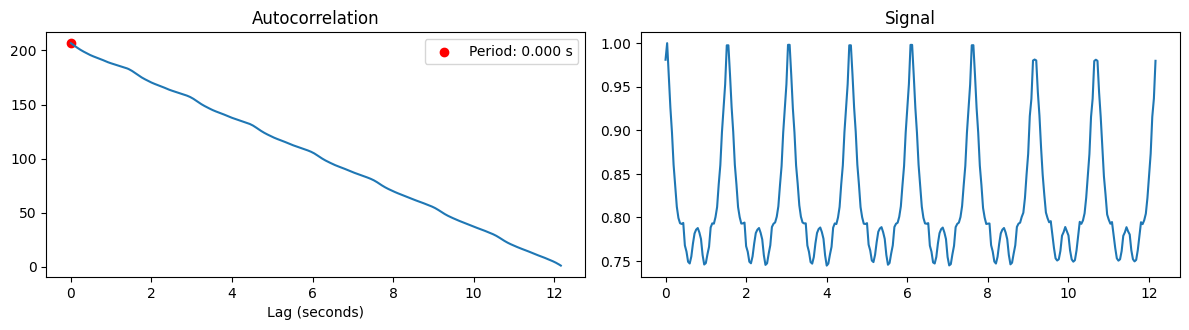

In [195]:
autoCorrelation(ls_PearsonCor2)

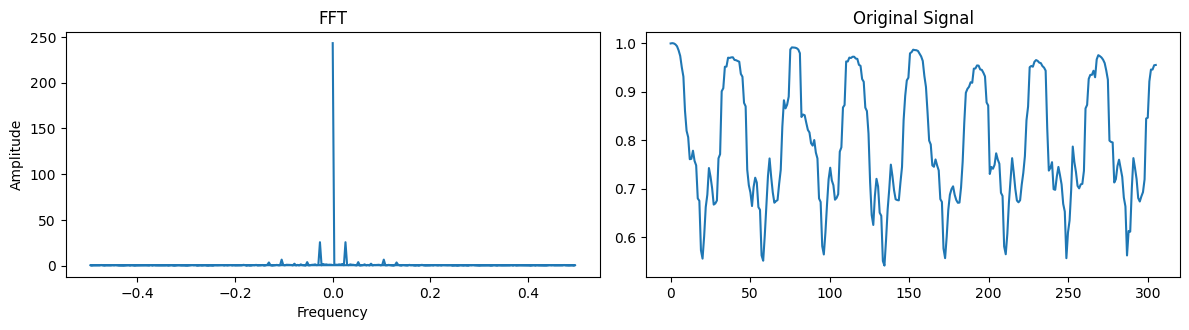

			Dominant Frequency: 0.026 , Period: 38.250


In [47]:
find_period(ls_Histogram)

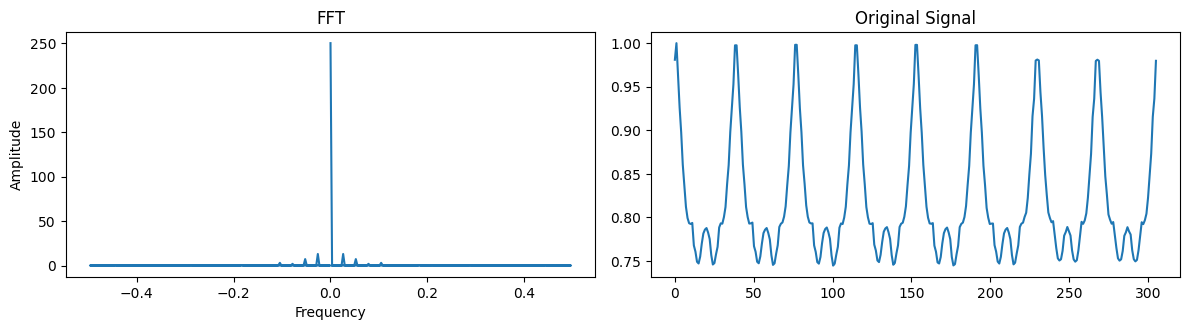

			Dominant Frequency: 0.026 , Period: 38.250


In [45]:
find_period(ls_PearsonCor2)

In [196]:
import zipfile

In [ ]:
zip_file = zipfile.ZipFile('frames.zip', 'w')
for i in range(305):
        image_file = "output_frames/frame_" + f"{i:04}" +".jpg"
        zip_file.write(image_file)
zip_file.close()

In [176]:
def cepstrumAnalysis(signal):
    # Define the signal
    fs = 305  # Sampling frequency
    #f = 20    # Frequency of the periodic signal
    t = np.arange(0, 1, 1/fs) # Time vector
    #signal = np.sin(2 * np.pi * f * t) + 0.5 * np.sin(2 * np.pi * 2 * f * t)  # Sum of two sine waves
    
    # Calculate the cepstrum
    spectrum = np.fft.fft(signal)
    log_spectrum = np.log(np.abs(spectrum))
    cepstrum = np.fft.ifft(log_spectrum)
    
    # Identify the peak
    cepstrum = np.abs(cepstrum) # Take the absolute value to get the real cepstrum
    peak_index = np.argmax(cepstrum[3:-3]) + 3 # Exclude first 5 samples
    
    # Calculate the period
    period = peak_index / fs
    
    # Plot the signal and the cepstrum
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 2)
    plt.plot((305/25)*t, signal)
    plt.title('Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 1)
    plt.plot((305/25)*np.arange(len(cepstrum))/fs, cepstrum)
    plt.title('Cepstrum')
    plt.xlabel('Quefrency (s)')
    plt.ylabel('Amplitude')
    plt.axvline(x=(305/25)*period, color='r', linestyle='--', label=f'Period = {(305/25)*period:.3f} s')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\t\tPeriod: {(305/25)*period:.3f} seconds\tPeriod: {305*period:.3f} frames")


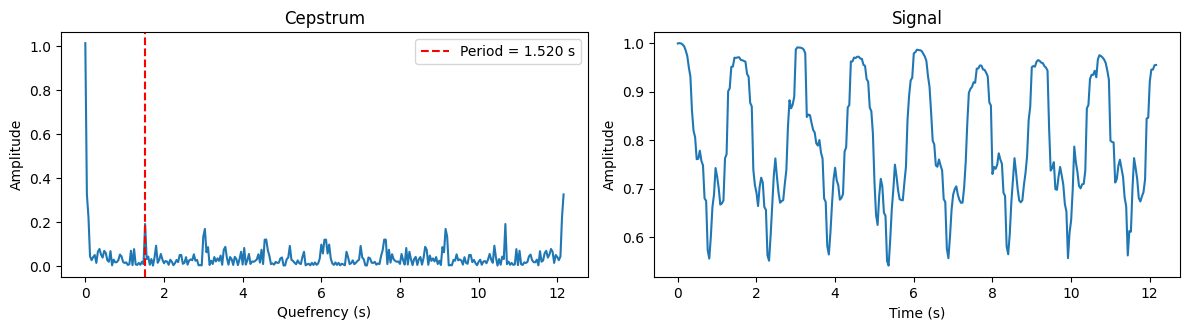

		Period: 1.520 seconds	Period: 38.000 frames


In [177]:
cepstrumAnalysis(ls_Histogram)

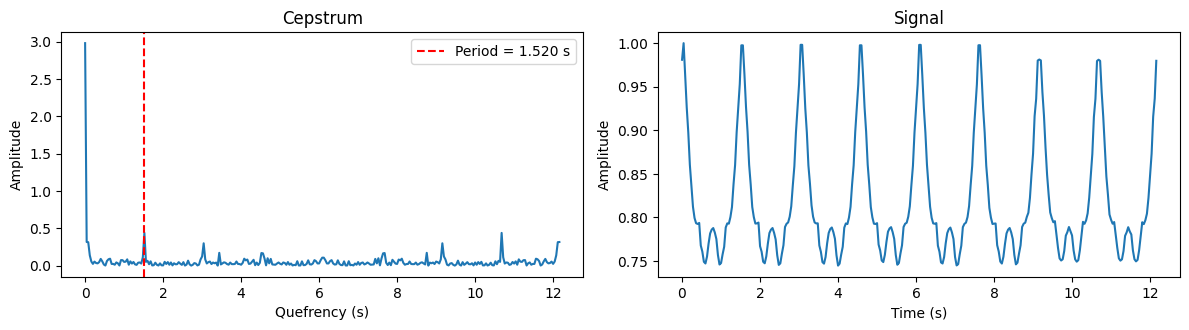

		Period: 1.520 seconds	Period: 38.000 frames


In [178]:
cepstrumAnalysis(ls_PearsonCor2)